# Pairwise distances with ONNX (pdist)

Function [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) computes pairwise distances between observations in n-dimensional space. It is not that difficult to convert that into *ONNX* when the dimension of the input is always the same. What if not?

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## Function pdist

The function [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) distances. Let's denote a list of vectors $(X_1, ..., X_n)$, function [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) returns the matrix $D=(d_{ij})$ where $d_{ij}=dist(X_i, X_j)=\lVert X_i - X_j \rVert^2$.

In [3]:
import numpy
from scipy.spatial.distance import pdist, squareform

M = numpy.array([[0, 1],
                 [1, 2],
                 [0.1, 1.1],
                 [2, 2]], dtype=float)

d1 = squareform(pdist(M, metric='sqeuclidean'))
d1

array([[0.  , 2.  , 0.02, 5.  ],
       [2.  , 0.  , 1.62, 1.  ],
       [0.02, 1.62, 0.  , 4.42],
       [5.  , 1.  , 4.42, 0.  ]])

The two following functions are implemented to reduce the number of allocations the algorithm requires.

In [4]:
def custom_pdist(M):
    n = M.shape[0]
    res = numpy.zeros((n, n))
    buffer = numpy.empty(M.shape)
    for i in range(n):
        numpy.subtract(M, M[i], out=buffer)  # broadcasted substraction
        numpy.square(buffer, out=buffer)
        res[i, :] = numpy.sum(buffer, axis=1)
    return res

d2 = custom_pdist(M)
d2

array([[0.  , 2.  , 0.02, 5.  ],
       [2.  , 0.  , 1.62, 1.  ],
       [0.02, 1.62, 0.  , 4.42],
       [5.  , 1.  , 4.42, 0.  ]])

This function computes $n^2$ distances wheres only $\frac{n(n-1)}{2}$ are necessary since the final matrix is symmetric. Let's change the implementation to reflect that.

In [5]:
def custom_pdist_lower(M):
    n = M.shape[0]
    res = numpy.zeros((n, n))
    buffer = numpy.empty((M.shape[0]-1, M.shape[1]))
    a = numpy.empty(M.shape[0])
    for i in range(1, n):
        numpy.subtract(M[:i], M[i], out=buffer[:i])  # broadcasted substraction
        numpy.square(buffer[:i], out=buffer[:i])
        numpy.sum(buffer[:i], axis=1, out=a[:i])
        res[:i, i] = a[:i]
        res[i, :i] = a[:i]
    return res

d3 = custom_pdist_lower(M)
d3

array([[0.  , 2.  , 0.02, 5.  ],
       [2.  , 0.  , 1.62, 1.  ],
       [0.02, 1.62, 0.  , 4.42],
       [5.  , 1.  , 4.42, 0.  ]])

## Loop mechanism in ONNX

Operator [Loop](https://github.com/onnx/onnx/blob/master/docs/Operators.md#Loop) seems appropriate but it is just a loop wheras [Scan](https://github.com/onnx/onnx/blob/master/docs/Operators.md#Scan) holds accumulator. The first graph is what is repeated inside the loop.

In [6]:
from skl2onnx.algebra.onnx_ops import OnnxAdd, OnnxIdentity, OnnxScan
from skl2onnx.common.data_types import FloatTensorType

initial = numpy.array([0, 0]).astype(numpy.float32).reshape((2,))
x = numpy.array([1, 2, 3, 4, 5, 6]).astype(numpy.float32).reshape((3, 2))

add_node = OnnxAdd('sum_in', 'next', output_names=['sum_out'])
id_node = OnnxIdentity(add_node, output_names=['scan_out'])

scan_body = id_node.to_onnx(
    {'sum_in': initial, 'next': initial},
    outputs=[('sum_out', FloatTensorType()),
             ('scan_out', FloatTensorType())])

%onnxview scan_body

The operator [Scan](https://github.com/onnx/onnx/blob/master/docs/Operators.md#Scan) repeats this graph a couple of times. *sum_in* is an accumulator, *next* is the iterated row from the input matrix.

In [7]:
node = OnnxScan('initial', 'x', output_names=['y', 'z'],
                num_scan_inputs=1, body=scan_body.graph)

model_def = node.to_onnx(
    {'initial': initial, 'x': x},
    outputs=[('y', FloatTensorType()),
             ('z', FloatTensorType())])

%onnxview model_def

In [8]:
from mlprodict.onnxrt import OnnxInference
oinf = OnnxInference(model_def)
res = oinf.run({'initial': initial, 'x': x})
res['y']

array([ 9., 12.], dtype=float32)

In [9]:
res['z']

array([[ 1.,  2.],
       [ 4.,  6.],
       [ 9., 12.]], dtype=float32)

## Back to pdist

[sklearn-onnx](https://github.com/onnx/sklearn-onnx) implements function *pdist* with *ONNX* operators. The parameter ``inputs=[('x', FloatTensorType())`` tels the method ``to_onnx`` that the dimension of the inputs is not fixed and should not be checked.

In [10]:
from skl2onnx.algebra.complex_functions import squareform_pdist

onnx_fct = OnnxIdentity(squareform_pdist('x'), output_names='Y')
model_def = onnx_fct.to_onnx(inputs=[('x', FloatTensorType())])
%onnxview model_def

Notice the double arrow. Input _x_ is used twice, once as an permanent state involved in broacasted substract, another time to iterator rows. On the other side, the first output of operator *Scan* is a permanent state equal to the input, the second one is an aggregation of results produced at each iteration. Each of those produces a row of a final matrix.

In [11]:
oinf = OnnxInference(model_def)
body = oinf['Scan', 'body']
%onnxview body.g

Let's now execute the graph and compare it with the original graph.

In [12]:
d1 = squareform(pdist(M, metric='sqeuclidean'))
d1

array([[0.  , 2.  , 0.02, 5.  ],
       [2.  , 0.  , 1.62, 1.  ],
       [0.02, 1.62, 0.  , 4.42],
       [5.  , 1.  , 4.42, 0.  ]])

In [13]:
oinf.run({'x': M})['Y']

array([[0.  , 2.  , 0.02, 5.  ],
       [2.  , 0.  , 1.62, 1.  ],
       [0.02, 1.62, 0.  , 4.42],
       [5.  , 1.  , 4.42, 0.  ]])

In [14]:
%timeit squareform(pdist(M, metric='sqeuclidean'))

24.6 µs ± 1.81 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%timeit custom_pdist(M)

38.1 µs ± 2.73 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%timeit custom_pdist_lower(M)

39.9 µs ± 3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit oinf.run({'x': M})['Y']

115 µs ± 3.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
M32 = M.astype(numpy.float32)

In [19]:
oinfrt = OnnxInference(model_def, runtime="onnxruntime-whole")
oinfrt.run({'x': M32})['Y']

array([[0.        , 2.        , 0.02000001, 5.        ],
       [2.        , 0.        , 1.6199999 , 1.        ],
       [0.02000001, 1.6199999 , 0.        , 4.42      ],
       [5.        , 1.        , 4.42      , 0.        ]], dtype=float32)

In [20]:
%timeit oinfrt.run({'x': M32})['Y']

45.8 µs ± 431 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Benchmark

In [21]:
from timeit import Timer


def measure_time(name, stmt, context, repeat=10, number=10):
    tim = Timer(stmt, globals=context)
    res = numpy.array(tim.repeat(repeat=repeat, number=number))
    res /= number
    mean = numpy.mean(res)
    dev = numpy.mean(res ** 2)
    dev = (dev - mean**2) ** 0.5
    return dict(average=mean, deviation=dev, min_exec=numpy.min(res),
                max_exec=numpy.max(res), repeat=repeat, number=number,
                nrows=context['M'].shape[0], ncols=context['M'].shape[1],
                name=name)

measure_time("scipy", "squareform(pdist(M, metric='sqeuclidean'))",
             context={'squareform': squareform, 'M': M,
                      'pdist': pdist})

{'average': 6.561174999994535e-05,
 'deviation': 1.4482786491173814e-05,
 'min_exec': 4.4444399999932215e-05,
 'max_exec': 8.78219999997043e-05,
 'repeat': 10,
 'number': 10,
 'nrows': 4,
 'ncols': 2,
 'name': 'scipy'}

In [22]:
from tqdm import trange

def generator():
    for feat in [5, 10, 50, 100]:
        for n in [5, 10, 20, 50, 100, 400, 1000]:
            if n <= 500 or feat <= 10:
                yield feat, n
            
all_values = list(generator())

rows = []

with trange(len(all_values)) as t:
    for i in t:        
        feat, n = all_values[i]
        t.set_description("feat=%d n=%d" % (feat, n))
        M = numpy.random.rand(n, feat)

        context = {'squareform': squareform, 'M': M, 'pdist': pdist}
        res = measure_time("scipy", "squareform(pdist(M, metric='sqeuclidean'))", context=context)
        res['dimres'] = squareform(pdist(M, metric='sqeuclidean')).shape[0]
        rows.append(res)

        context = {'M': M, 'custom_pdist': custom_pdist}
        res = measure_time("numpy", "custom_pdist(M)", context=context)
        res['dimres'] = custom_pdist(M).shape[0]
        rows.append(res)

        context = {'M': M, 'custom_pdist_lower': custom_pdist_lower}
        res = measure_time("numpy-lower", "custom_pdist_lower(M)", context=context)
        res['dimres'] = custom_pdist_lower(M).shape[0]
        rows.append(res)

        context = {'oinf': oinf, 'M': M}
        res = measure_time("onnx-py", "oinf.run({'x': M})['Y']", context=context)
        res['dimres'] = oinf.run({'x': M})['Y'].shape[0]
        rows.append(res)

        M32 = M.astype(numpy.float32)
        context = {'oinfrt': oinfrt, 'M': M32}
        res = measure_time("onnx-rt", "oinfrt.run({'x': M})['Y']", context=context)
        res['dimres'] = oinfrt.run({'x': M32})['Y'].shape[0]
        rows.append(res)

    
from pandas import DataFrame
df = DataFrame(rows)
df.head()

feat=100 n=400: 100%|██████████| 26/26 [01:33<00:00,  7.10s/it]


,average,deviation,dimres,max_exec,min_exec,name,ncols,nrows,number,repeat
0,0.000040,0.000023,5,0.000097,0.000025,scipy,5,5,10,10
1,0.000085,0.000037,5,0.000165,0.000057,numpy,5,5,10,10
2,0.000061,0.000009,5,0.000085,0.000057,numpy-lower,5,5,10,10
3,0.000260,0.000132,5,0.000558,0.000147,onnx-py,5,5,10,10
4,0.000188,0.000086,5,0.000381,0.000088,onnx-rt,5,5,10,10


In [23]:
from pandas import pivot_table
piv = pivot_table(df, index=["nrows"], columns= ['ncols', 'name'], values='average')
piv.head().T

nrows                   5         10        20        50        100
ncols name                                                         
5     numpy        0.000085  0.000188  0.000203  0.000531  0.001172
      numpy-lower  0.000061  0.000122  0.000245  0.000622  0.001339
      onnx-py      0.000260  0.000272  0.000530  0.001343  0.003466
      onnx-rt      0.000188  0.000090  0.000165  0.000464  0.001306
      scipy        0.000040  0.000053  0.000035  0.000040  0.000074
10    numpy        0.000075  0.000131  0.000281  0.001695  0.001461
      numpy-lower  0.000054  0.000136  0.000314  0.001186  0.001417
      onnx-py      0.000180  0.000390  0.000796  0.001694  0.002976
      onnx-rt      0.000082  0.000122  0.000333  0.000645  0.001360
      scipy        0.000032  0.000029  0.000038  0.000072  0.000113
50    numpy        0.000051  0.000110  0.000243  0.000781  0.002222
      numpy-lower  0.000051  0.000114  0.000276  0.000766  0.002062
      onnx-py      0.000147  0.000280  0.000584  0.001634  0.003790
      onnx-rt      0.000070  0.000118  0.000266  0.001042  0.003267
      scipy        0.000041  0.000029  0.000045  0.000090  0.000266
100   numpy        0.000107  0.000117  0.000273  0.001001  0.003082
      numpy-lower  0.000053  0.000118  0.000304  0.000865  0.002238
      onnx-py      0.000157  0.000298  0.000610  0.001900  0.004607
      onnx-rt      0.000077  0.000145  0.000377  0.001662  0.005852
      scipy        0.000042  0.000030  0.000054  0.000172  0.000555

In [24]:
%matplotlib inline

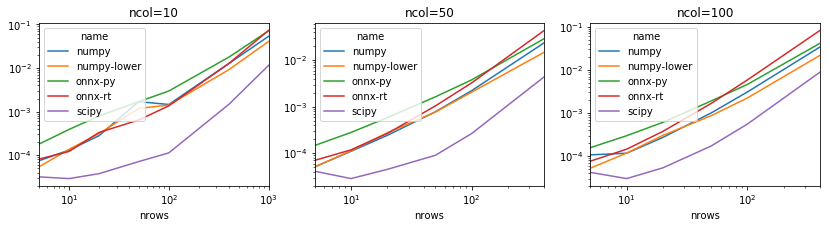

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
for i, ncol in enumerate([10, 50, 100]):
    piv = df[df.ncols==ncol].pivot("nrows", "name", "average")
    piv.plot(ax=ax[i], logy=True, logx=True)
    ax[i].set_title("ncol=%d" % ncol)
ax;

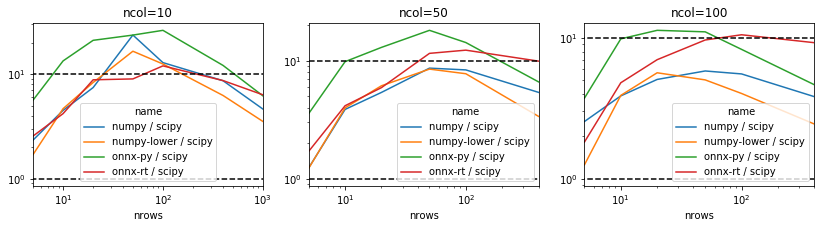

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
for i, ncol in enumerate([10, 50, 100]):
    piv = df[df.ncols==ncol].pivot("nrows", "name", "average")
    piv['numpy / scipy'] = piv['numpy'] / piv['scipy']
    piv['numpy-lower / scipy'] = piv['numpy-lower'] / piv['scipy']
    piv['onnx-py / scipy'] = piv['onnx-py'] / piv['scipy']
    piv['onnx-rt / scipy'] = piv['onnx-rt'] / piv['scipy']
    piv = piv[['numpy / scipy', 'numpy-lower / scipy', 
               'onnx-py / scipy', 'onnx-rt / scipy']]
    piv.plot(ax=ax[i], logy=True, logx=True)
    ax[i].plot([0, max(piv.index)], [1, 1], '--', color='black')
    ax[i].plot([0, max(piv.index)], [10, 10], '--', color='black')
    ax[i].set_title("ncol=%d" % ncol)
ax;

Curves are not linear and rather difficult to interpret. The algorithm *numpy-lower* and *scipy* should be close as the cost of both algorithm are similar. However, *scipy* reduces the number of trips between C and python. The C implementation of the distance is here:
[sqeuclidean_distance_double](https://github.com/scipy/scipy/blob/master/scipy/spatial/src/distance_impl.h#L50). The final cost is a combination of computation, multithreading, allocations...

In [27]:
from pyquickhelper.pycode.profiling import profile
M = numpy.random.rand(100, 10)

pr1, df1 = profile(lambda: [squareform(pdist(M, metric='sqeuclidean')) for i in range(0, 1000)], as_df=True)
pr2, df2 = profile(lambda: [custom_pdist_lower(M) for i in range(0, 1000)], as_df=True)

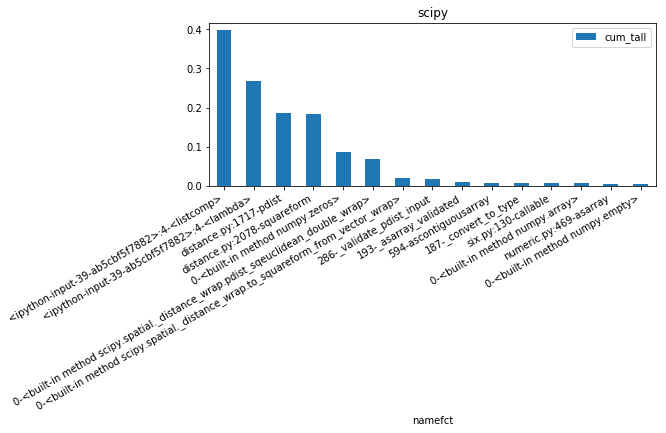

In [28]:
ax = df1[['namefct', 'cum_tall']].head(n=15).set_index('namefct').plot(kind='bar', figsize=(8, 3), rot=30)
ax.set_title("scipy")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right')

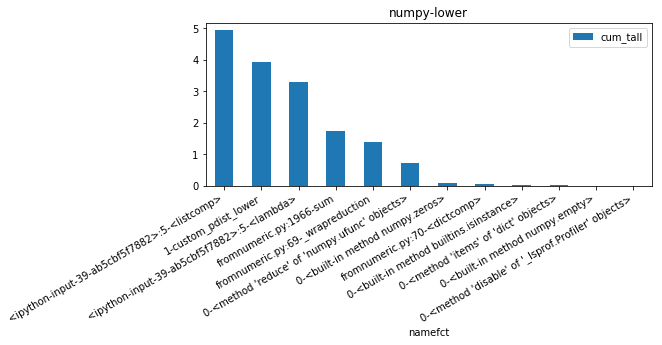

In [29]:
ax = df2[['namefct', 'cum_tall']].head(n=15).set_index('namefct').plot(kind='bar', figsize=(8, 3), rot=30)
ax.set_title("numpy-lower")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');    

[Universal function](https://docs.scipy.org/doc/numpy/reference/ufuncs.html) do not seem to be very efficient in our case.

## Discussion

The final question is: should we introduce a new operator into [ONNX specifications](https://github.com/onnx/onnx/blob/master/docs/Operators.md)? The function [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) is not necessarily often used for a big number of observations as the square matrix it produces will even bigger. It seems reasonable. We showed that a python runtime based on *numpy* would not help, the implementation must be done in C++.